# Assignment 1 - Propagation Settings

In [1]:
''' 
Copyright (c) 2010-2020, Delft University of Technology
All rigths reserved

This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.
'''

import numpy as np
from tudatpy import elements
from tudatpy.io import save2txt
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice_interface
from tudatpy.kernel.simulation import environment_setup
from tudatpy.kernel.simulation import propagation_setup
from matplotlib import pyplot as plt

In [2]:
# # student number: 1244779 --> 1244ABC
A = 7
B = 2
C = 6

simulation_start_epoch = 33.15 * constants.JULIAN_YEAR + A * 7.0 * constants.JULIAN_DAY + \
                            B * constants.JULIAN_DAY + C * constants.JULIAN_DAY / 24.0
simulation_end_epoch = simulation_start_epoch + 344.0 * constants.JULIAN_DAY / 24.0

## Create environment, vehicle, accelerations, and propagation settings

In [3]:
###########################################################################
# CREATE ENVIRONMENT ######################################################
###########################################################################

# Load spice kernels.
spice_interface.load_standard_kernels()

# Create settings for celestial bodies
bodies_to_create = ["Ganymede","Sun","Saturn","Jupiter","Io","Callisto","Europa"]
global_frame_origin = "Ganymede"
global_frame_orientation = "ECLIPJ2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Add Ganymede exponential atmosphere
density_scale_height = 40.0E3
density_at_zero_altitude = 2.0E-9
body_settings.get( "Ganymede" ).atmosphere_settings = environment_setup.atmosphere.exponential( 
        density_scale_height, density_at_zero_altitude)

bodies = environment_setup.create_system_of_bodies(body_settings)

###########################################################################
# CREATE VEHICLE ##########################################################
###########################################################################

# Create vehicle object
bodies.create_empty_body( "JUICE" )

# Set mass of vehicle
bodies.get_body( "JUICE" ).set_constant_mass(2000.0)
    
# Create aerodynamic coefficients interface
reference_area = 100.0
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
        reference_area,[drag_coefficient,0,0] )
environment_setup.add_aerodynamic_coefficient_interface(
                bodies, "JUICE", aero_coefficient_settings )

# Create pressure coefficients interface

reference_area_radiation = 100.0
radiation_pressure_coefficient = 1.2
occulting_bodies = ["Ganymede"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)

environment_setup.add_radiation_pressure_interface(
            bodies, "JUICE", radiation_pressure_settings )

###########################################################################
# CREATE ACCELERATIONS ####################################################
###########################################################################

# Define bodies that are propagated, and their central bodies of propagation.
bodies_to_propagate = ["JUICE"]
central_bodies = ["Ganymede"]

# Define accelerations acting on vehicle.
acceleration_settings_on_vehicle = dict(
    Ganymede=
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(2, 2),
        propagation_setup.acceleration.aerodynamic()
    ],
    Jupiter=
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(4,0)
    ],
    Sun=
    [
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Saturn=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Io=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Europa=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Callisto=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ]

)

# Create global accelerations dictionary.
acceleration_settings = {"JUICE": acceleration_settings_on_vehicle}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies)


###########################################################################
# CREATE PROPAGATION SETTINGS #############################################
###########################################################################

# Define initial state.
system_initial_state = spice_interface.get_body_cartesian_state_at_epoch(
    target_body_name="JUICE",
    observer_body_name="Ganymede",
    reference_frame_name="ECLIPJ2000",
    aberration_corrections="NONE",
    ephemeris_time= simulation_start_epoch )

dependent_variables_to_save = [
    propagation_setup.dependent_variable.keplerian_state(
        "JUICE", "Ganymede"),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "JUICE", "Ganymede" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.aerodynamic_type, "JUICE", "Ganymede" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.spherical_harmonic_gravity_type, "JUICE", "Jupiter" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "JUICE", "Saturn" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "JUICE", "Europa" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "JUICE", "Io" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "JUICE", "Callisto" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.point_mass_gravity_type, "JUICE", "Sun" ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.cannonball_radiation_pressure_type, "JUICE", "Sun" ),
    propagation_setup.dependent_variable.spherical_harmonic_terms_acceleration_norm( "JUICE", "Ganymede", [(0,0),(2,0),(2,2)] ),
    propagation_setup.dependent_variable.spherical_harmonic_terms_acceleration_norm( "JUICE", "Jupiter", [(0,0),(2,0),(4,0)] )

]

# Create propagation settings.
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    system_initial_state,
    simulation_end_epoch,
    output_variables = dependent_variables_to_save
)
    
# Create numerical integrator settings.
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch,
    fixed_step_size
)

## Propagate Orbit

In [4]:
# Create simulation object and propagate dynamics.
dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
    bodies, integrator_settings, propagator_settings, True)

simulation_result = dynamics_simulator.state_history
dependent_variables = dynamics_simulator.dependent_variable_history

## Print final propagation time and state

In [5]:
###########################################################################
# PRINT FINAL PROPAGATION TIME AND STATE ##################################
###########################################################################

final_time_step=list(simulation_result.keys())[-1]
first_time_step=list(simulation_result.keys())[0]

print(
    f"""
JUICE Propagation Results.

Final propagation time of JUICE [s]: {simulation_end_epoch}
Final Cartesian state of JUICE is [m]: \n{
    simulation_result[final_time_step][:]}

    """
)




JUICE Propagation Results.

Final propagation time of JUICE [s]: 1051800840.0
Final Cartesian state of JUICE is [m]: 
[-2.52684000e+06 -1.28252770e+06  1.27036137e+06  5.08056542e+02
  6.16008130e+02  1.60462826e+03]

    


## Save Results

In [6]:
###########################################################################
# SAVE RESULTS ############################################################
###########################################################################

save2txt(solution=simulation_result,
         filename="JUICEPropagationHistory_Q3.dat",
         directory="./",  # default = "./" 
         column_names=None,  # default = None 
         )

save2txt(solution=dependent_variables,
         filename="JUICEPropagationHistory_DependentVariables_Q3.dat",
         directory="./",  # default = "./" 
         column_names=None,  # default = None 
        )

lines = ['\n']*11 

q_n = 3 #question number

with open('cartesian_results_AE4868_2020_A1_5382726.txt','r') as f:
    file_lines = f.readlines()

for i, file_line in enumerate(file_lines):
    lines[i] = file_line

line = f'{simulation_end_epoch}'
for item in simulation_result[final_time_step][:]:
    line = ' '.join((line,str(item)))
line += '\n'

lines[q_n-1] = line
with open('cartesian_results_AE4868_2020_A1_5382726.txt','w') as f:
    f.writelines(lines)

## Plot Results

For inspiration see: 

https://tudat-space.readthedocs.io/en/latest/_src_first_steps/simulations/example_application_2.html#visualize-results

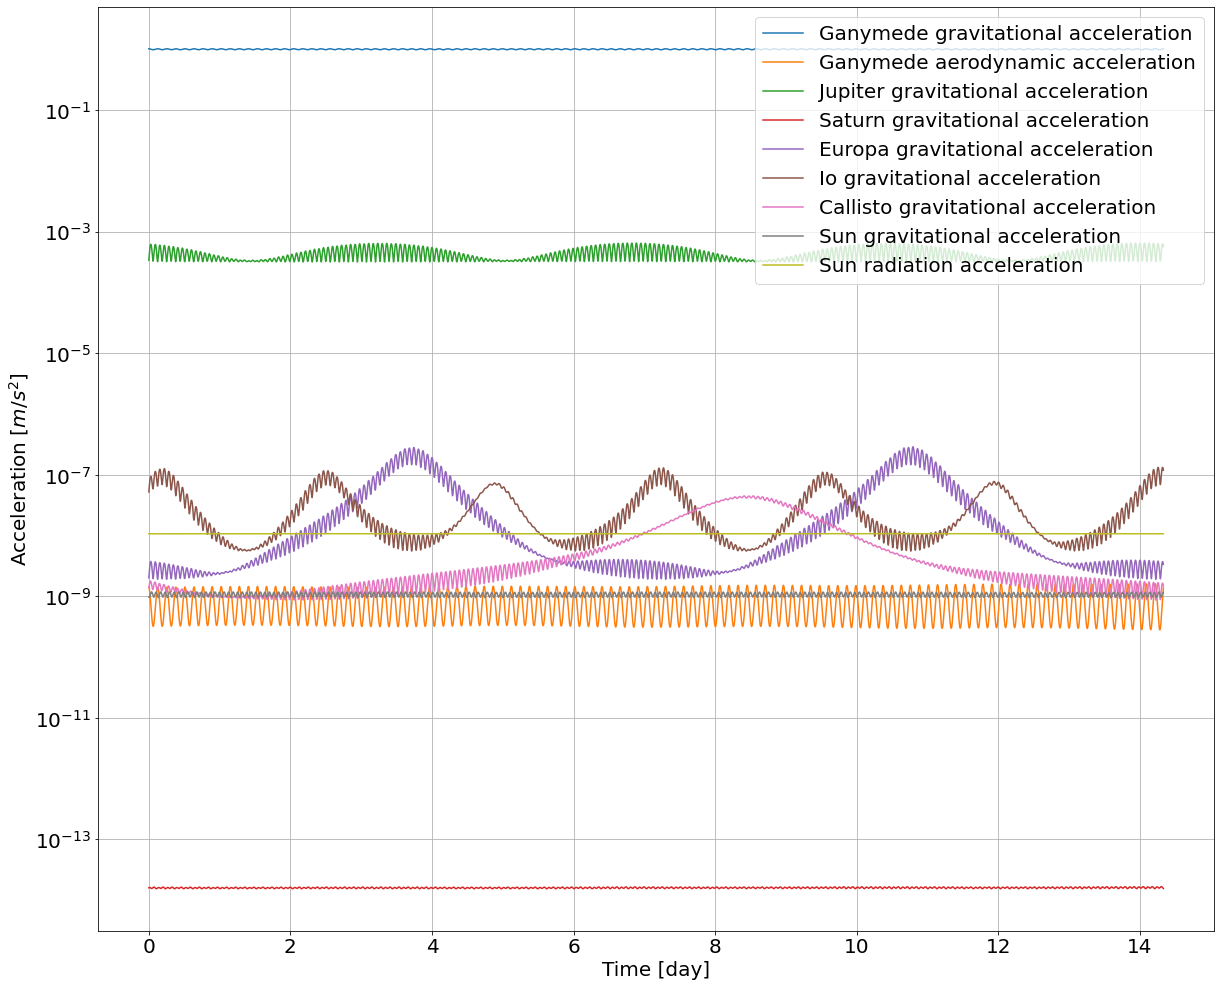

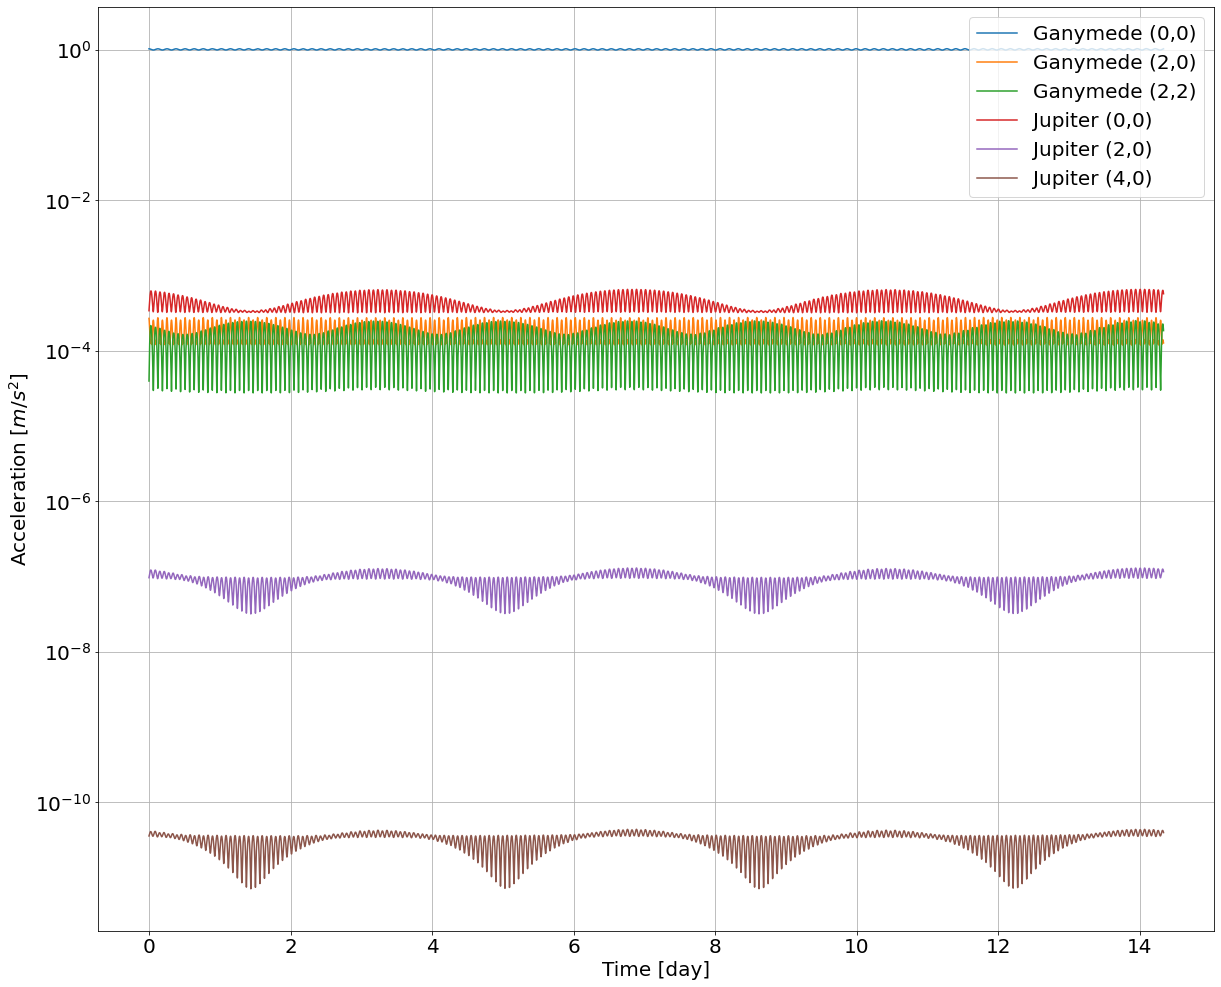

In [7]:
###########################################################################
# PLOT RESULTS ############################################################
###########################################################################

# Extract time and Kepler elements from dependent variables
elements = np.vstack(list(dependent_variables.values()))
                            
# Kepler Elements
# 0: semi-major axis
# 1: eccentricity
# 2: inclination
# 3: argument of periapsis
# 4: right ascension of the ascending node
# 5: true anomaly

time = dependent_variables.keys()
time_days = [ t / constants.JULIAN_DAY - simulation_start_epoch / constants.JULIAN_DAY for t in time ]


ganymede_gravitational_parameter = body_settings.get( "Ganymede" ).gravity_field_settings.get_gravitational_parameter( )
ganymede_normalized_c20 = body_settings.get( "Ganymede" ).gravity_field_settings.get_cosine_coefficients( )[2,0]
ganymede_reference_radius = body_settings.get( "Ganymede" ).gravity_field_settings.get_reference_radius( )

# Set font size of figures
font_size = 20
plt.rcParams.update({'font.size': font_size}) 

plt.figure(1, figsize=(20,17))
# Ganymede gravity
plt.plot(time_days, elements[:,6], label='Ganymede gravitational acceleration')

# Ganymede aero
plt.plot(time_days, elements[:,7], label='Ganymede aerodynamic acceleration')

# Jupiter gravity
plt.plot(time_days, elements[:,8], label='Jupiter gravitational acceleration')

# Saturn gravity
plt.plot(time_days, elements[:,9], label='Saturn gravitational acceleration')

# Europa gravity
plt.plot(time_days, elements[:,10], label='Europa gravitational acceleration')

# Io gravity
plt.plot(time_days, elements[:,11], label='Io gravitational acceleration')

# Callisto gravity
plt.plot(time_days, elements[:,12], label='Callisto gravitational acceleration')

# Sun gravity
plt.plot(time_days, elements[:,13], label='Sun gravitational acceleration')

# Sun rad
plt.plot(time_days, elements[:,14], label='Sun radiation acceleration')

plt.legend(loc='upper right')
plt.semilogy()
plt.xlabel('Time [day]')
plt.ylabel(r'Acceleration $[m/s^2]$')
plt.grid()
plt.savefig( fname = 'figures/part_i_Q3.png')

plt.figure(2, figsize=(20,17))
# Ganymede (0,0)
plt.plot(time_days, elements[:,15], label='Ganymede (0,0)')

# Ganymede (2,0)
plt.plot(time_days, elements[:,16], label='Ganymede (2,0)')

# Ganymede (2,2)
plt.plot(time_days, elements[:,17], label='Ganymede (2,2)')

# Jupiter (0,0)
plt.plot(time_days, elements[:,18], label='Jupiter (0,0)')

# Jupiter (2,0)
plt.plot(time_days, elements[:,19], label='Jupiter (2,0)')

# Jupiter (4,0)
plt.plot(time_days, elements[:,20], label='Jupiter (4,0)')


plt.legend(loc='upper right')
plt.semilogy()
plt.xlabel('Time [day]')
plt.ylabel(r'Acceleration $[m/s^2]$')
plt.grid()
plt.savefig( fname = 'figures/part_ii_Q3.png')
plt.show()


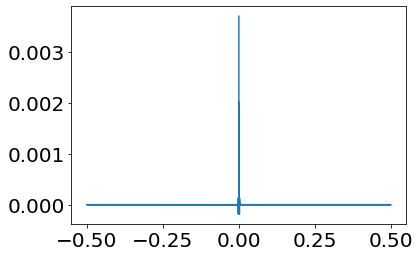

In [8]:
fft = np.fft.fft(elements[:,11])
freq = np.fft.fftfreq(len(time_days))

plt.plot(freq, fft.real)
plt.show()

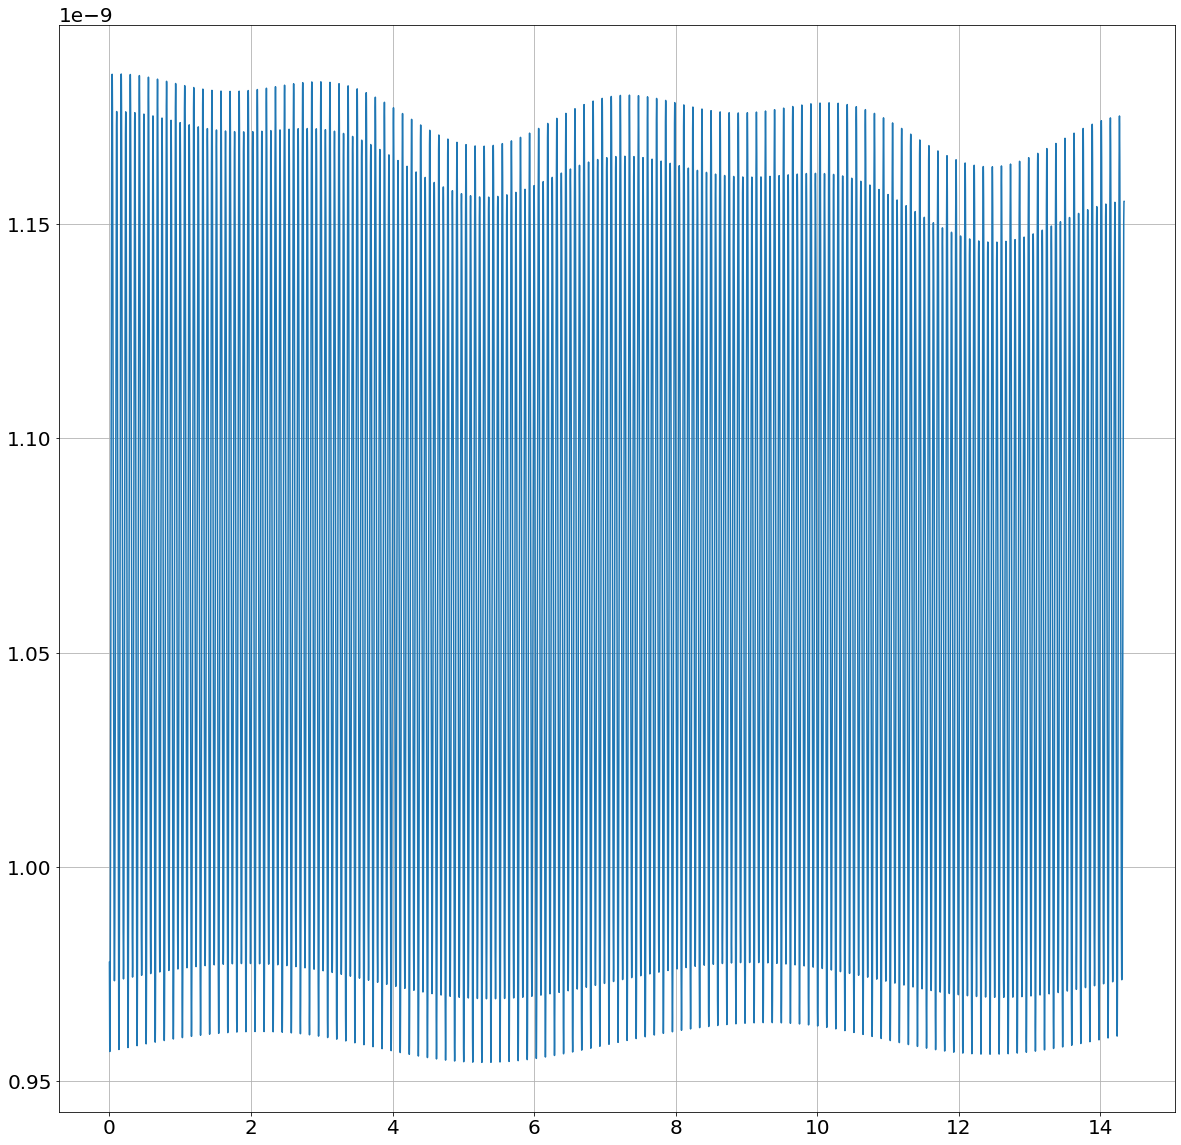

In [9]:
fig, ((ax1)) = plt.subplots( 1, 1, figsize = (20,20) )
ax1.plot(time_days, elements[:,13], label='Sun gravitational acceleration')
ax1.grid()

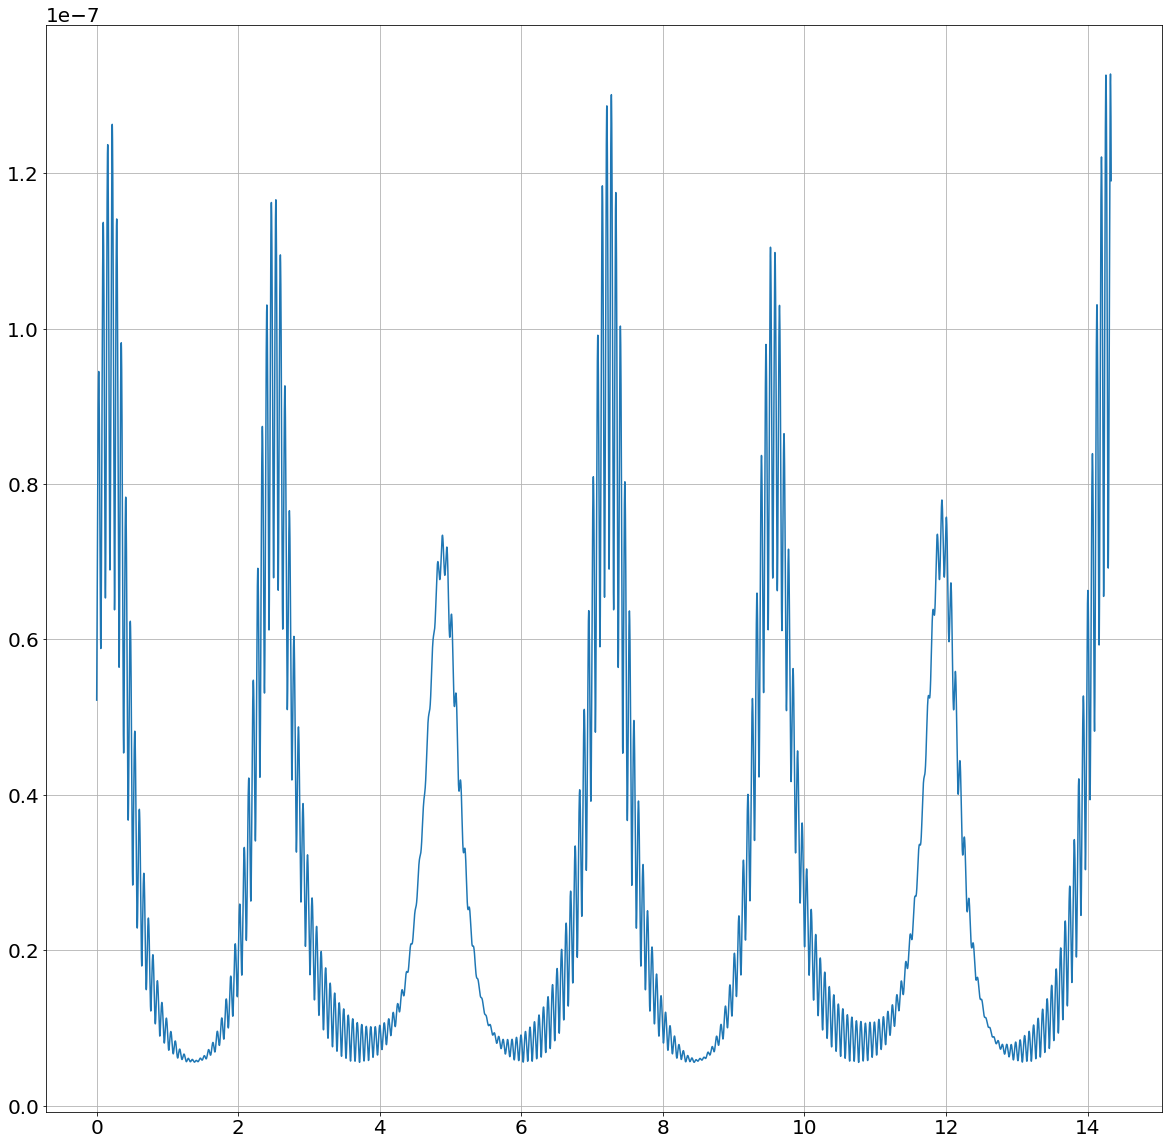

In [10]:

fig, ((ax2)) = plt.subplots( 1, 1, figsize = (20,20) )
ax2.plot(time_days, elements[:,11], label='Io gravitational acceleration')
ax2.grid()



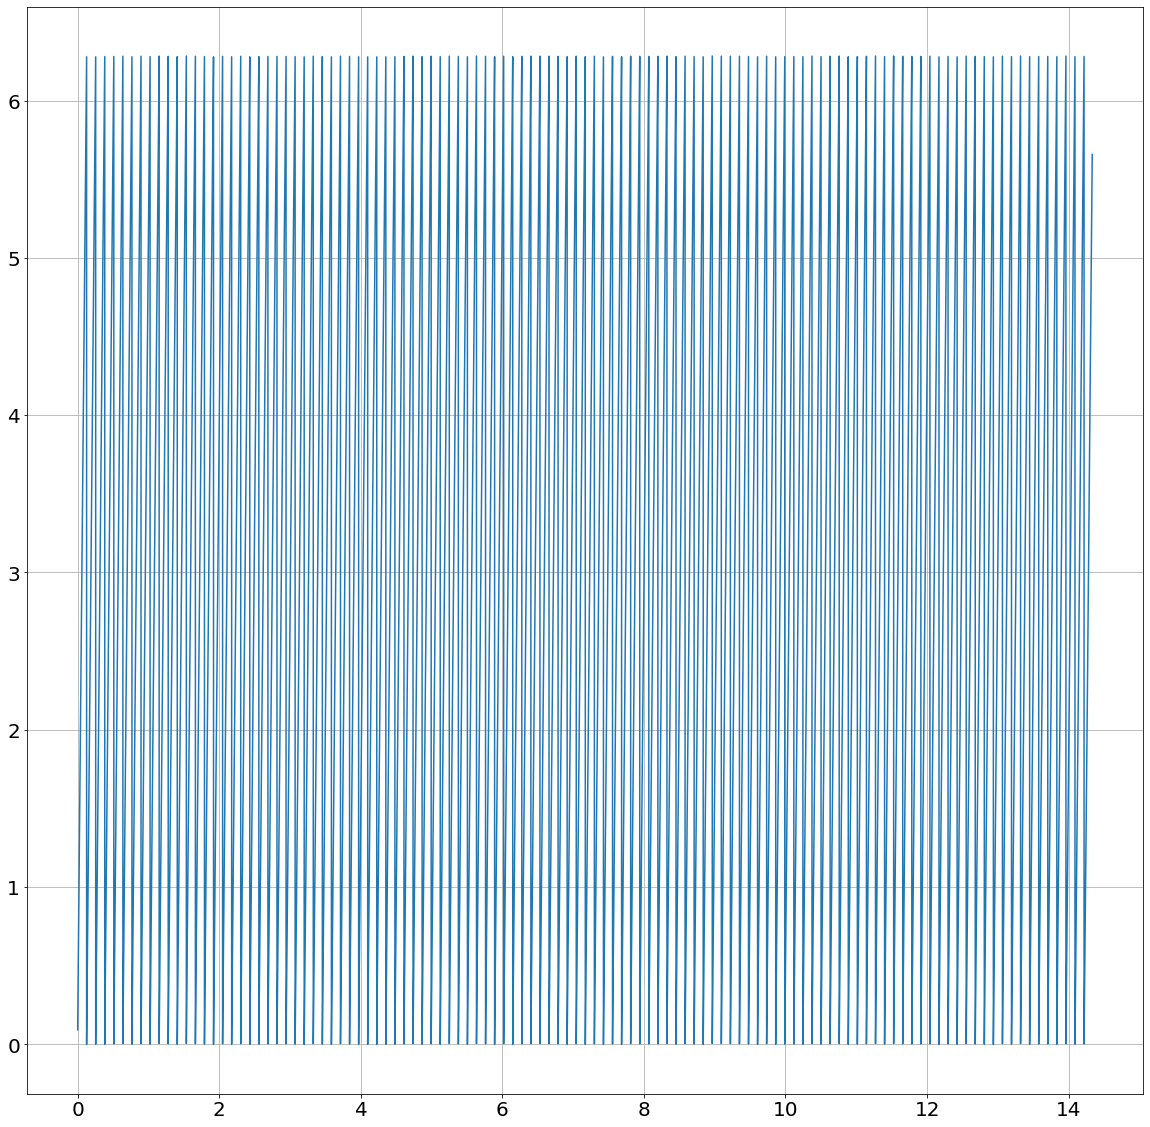

In [11]:
fig, ((ax3)) = plt.subplots( 1, 1, figsize = (20,20) )
ax3.plot(time_days, elements[:,5], label='Sun gravitational acceleration')
ax3.grid()